In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#### Sigmoid函数

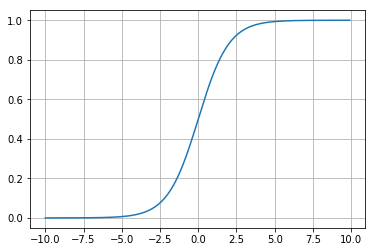

In [3]:
def sigmoid(x):
    return (1 / ( 1 + np.exp(-x)))

x_sig = np.arange(-10, 10, 0.1)
plt.plot(x_sig, sigmoid(x_sig))
plt.grid()

### 生成随机数据

In [4]:
def generateRandomData(m, x_scale, noise_factor=0.2):
    (x_min, x_max) = x_scale
    x_range = x_max - x_min # max value of x
    x = np.random.random(size=(m, 2))
    noise = (np.random.random(size=(m, 1)) - 0.5 ) * x_range * noise_factor
    y = (sigmoid(x[:,0].reshape(m ,1) + x[:,1].reshape(m ,1) + noise - x_range) > 0.5).astype('int')
    X = np.c_[np.ones(m), x]
    return (X, y)

X, y = generateRandomData(100, (0, 1), 0.4)
m = y.shape[0]
print(sum(y.ravel()))

49


#### 对数据进行可视化

In [5]:
def plotData(X, y, xlabel='x_1', ylabel='x_2', axes=None, label_pos='positive', label_neg='negative'):
    pos_index = y[:, 0] == 1
    neg_index = y[:, 0] == 0
    if axes == None:
        axes = plt.gca()
    axes.scatter(X[pos_index][:,1], X[pos_index][:,2], marker='+', c='k', label=label_pos)
    axes.scatter(X[neg_index][:,1], X[neg_index][:,2], marker='o', c='y',  label=label_neg)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.legend();

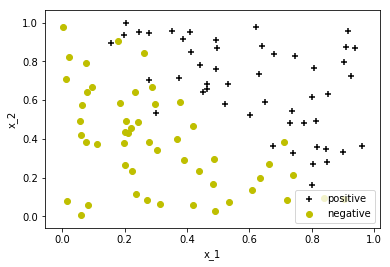

In [6]:
plotData(X, y)

### 逻辑回归

In [8]:
def computeCost(theta, X, y):
    h = sigmoid(X.dot(theta))
    J = -1/m * (np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    if np.isnan(J[0]):
        return np.inf
    return (J[0])

In [9]:
def costGradient(theta, X, y):
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    grad = 1/m * X.T.dot(h-y)
    return (grad.flatten())

In [10]:
theta_init = np.zeros(X.shape[1])
cost = computeCost(theta_init, X, y)
grad = costGradient(theta_init, X, y)
print('cost: %s\n'%cost, 'Gradient: %s' %grad)

cost: 0.6931471805599452
 Gradient: [ 0.01       -0.072171   -0.06942994]


解决优化问题
- scipy 中的 [minimize](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html) 方法
- [雅可比矩阵](https://zh.wikipedia.org/wiki/%E9%9B%85%E5%8F%AF%E6%AF%94%E7%9F%A9%E9%98%B5)

In [11]:
res = minimize(computeCost, theta_init, args=(X,y), method=None, jac=costGradient, options={'maxiter': 10000})
print(res)

      fun: 0.1628786799187488
 hess_inv: array([[ 1723.90241342, -1710.33697034, -1596.29528062],
       [-1710.33697034,  1778.69790791,  1539.87907734],
       [-1596.29528062,  1539.87907734,  1556.08013476]])
      jac: array([-1.03395288e-07, -2.21225491e-06,  3.86012599e-06])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 27
     njev: 28
   status: 0
  success: True
        x: array([-18.35363853,  18.60568199,  17.70121615])


#### 验证训练集的准确率

In [12]:
def predict(theta, x, threshold=0.5):
    return (sigmoid(x.dot(theta.T)) >= threshold).astype('int')

In [13]:
p = predict(res.x, X)
accuracy = sum(p == y.flatten()) / y.size
print(accuracy)

0.93


#### 决策边界

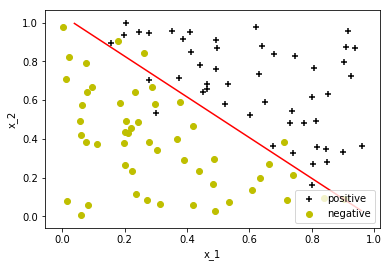

In [14]:
plotData(X, y)
x1_min, x1_max = X[:,1].min(), X[:,1].max()
x2_min, x2_max = X[:,2].min(), X[:,2].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x)).reshape(xx1.shape)
# print(h.shape)
plt.contour(xx1, xx2, h, [0.5], colors='r')

#### 测试数据验证

In [15]:
X_test, y_test = generateRandomData(100, (0,1))
print(sum(y_test.ravel()))

54


In [24]:
p_test = predict(res.x, X_test)
accuary_test = sum(p_test == y_test.flatten())/ y_test.size
print(accuary_test)

0.94


### 多项式逻辑回归与正则化

In [25]:
def generateRadialData(m, radius, noise_factor=0.2):
    angle = np.random.random((m,1)) * 2 * np.pi
    r_min = radius * 0.3
    r = r_min + np.random.random((m,1)) * radius
    x = np.c_[np.cos(angle) * r, np.sin(angle) * r]
    noise_x = (np.random.random((m,1)) - 0.5) * radius * noise_factor
    y = (sigmoid(r + noise_x - 0.5*radius - r_min) > 0.5).astype('int')
    return (x, y)

In [26]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [27]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    return(grad.flatten())

In [28]:
initial_theta = np.zeros(XX.shape[1])
costFunctionReg(initial_theta, 1, XX, y)

0.6931471805599452

(50, 15) (50, 1)
19


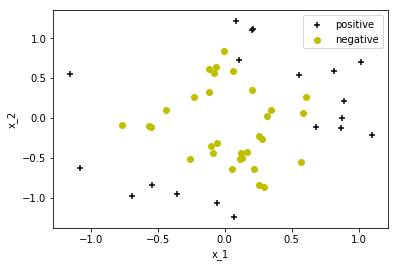

In [29]:
m = 50
degree = 4
X, y = generateRadialData(m, 1, 0.3)
poly = PolynomialFeatures(degree)
XX = poly.fit_transform(X)
print(XX.shape, y.shape)
plotData(XX, y)
print(np.sum(y))

ValueError: shapes (50,15) and (10,1) not aligned: 15 (dim 1) != 10 (dim 0)

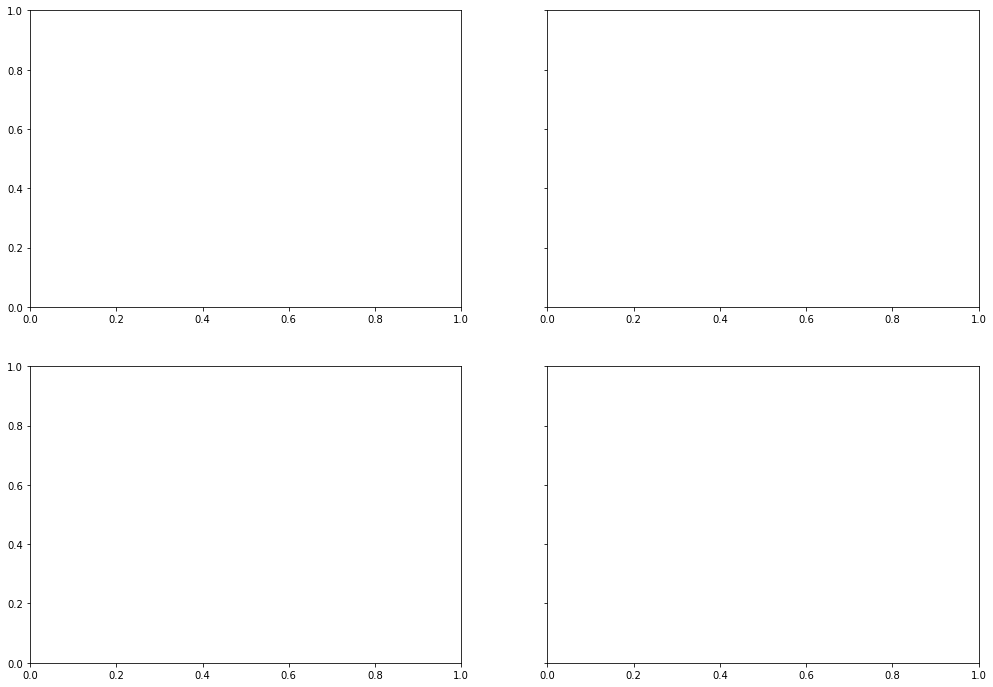

In [30]:
fig, axes = plt.subplots(2,2, sharey = True, figsize=(17,12))

for i, C in enumerate([0, 0.01, 0.1, 1]):
    
    # Optimize costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    
    print(accuracy)

    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    
    plotData(XX, y, axes=axes.flatten()[i])
    
    axes.flatten()[i].contour(xx1, xx2, h, [0.5])
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))